In [1]:
!pwd

/content


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [3]:
import numpy as np 
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

In [4]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [9]:
%cd /content/gdrive/MyDrive/Folder/

/content/gdrive/MyDrive/Folder


In [5]:
df_labels = pd.read_csv('/content/gdrive/MyDrive/Folder/GroundTruth.csv')
df_labels['image'] = df_labels['image'] +'.jpg'

labels=['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
label_list=[]
for i in range (len(df_labels)):
    row= list(df_labels.iloc[i])
    del row[0]
    index=np.argmax(row)
    label=labels[index]
    label_list.append(label)
df_labels['label']= label_list
df_labels=df_labels.drop(labels, axis=1)
df_labels['label'].value_counts()

NV       6705
MEL      1113
BKL      1099
BCC       514
AKIEC     327
VASC      142
DF        115
Name: label, dtype: int64

In [6]:
df_labels.head()

,image,label
0,ISIC_0024306.jpg,NV
1,ISIC_0024307.jpg,NV
2,ISIC_0024308.jpg,NV
3,ISIC_0024309.jpg,NV
4,ISIC_0024310.jpg,MEL


In [7]:
sdir=r'/content/gdrive/MyDrive/Folder//images' # main directory where data is stored
save_dir=r'./' # output directory where model will be saved
subject='cancer' # part of the name of the saved model
height=64  # image height
width=64   # image width
channels=3  # number of coloor channels
batch_size=40  # model batch size for training and evaluation
img_shape=(height, width, channels)
img_size=(height, width)

def scalar(img): # unused for efficientnet model
    return img/127.5-1  # scale pixel between -1 and +1
gen=ImageDataGenerator() # no scaling of pixels is need for efficientnet

df_gen=gen.flow_from_dataframe( df_labels, sdir, x_col='image', y_col='label', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

Found 10015 validated image filenames belonging to 7 classes.


In [8]:
def show_image_samples(gen):
    test_dict=gen.class_indices
    classes=list(test_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]/255 # scale images between 0 and 1 becaue no preprocessing scaling was done for efficientnet
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

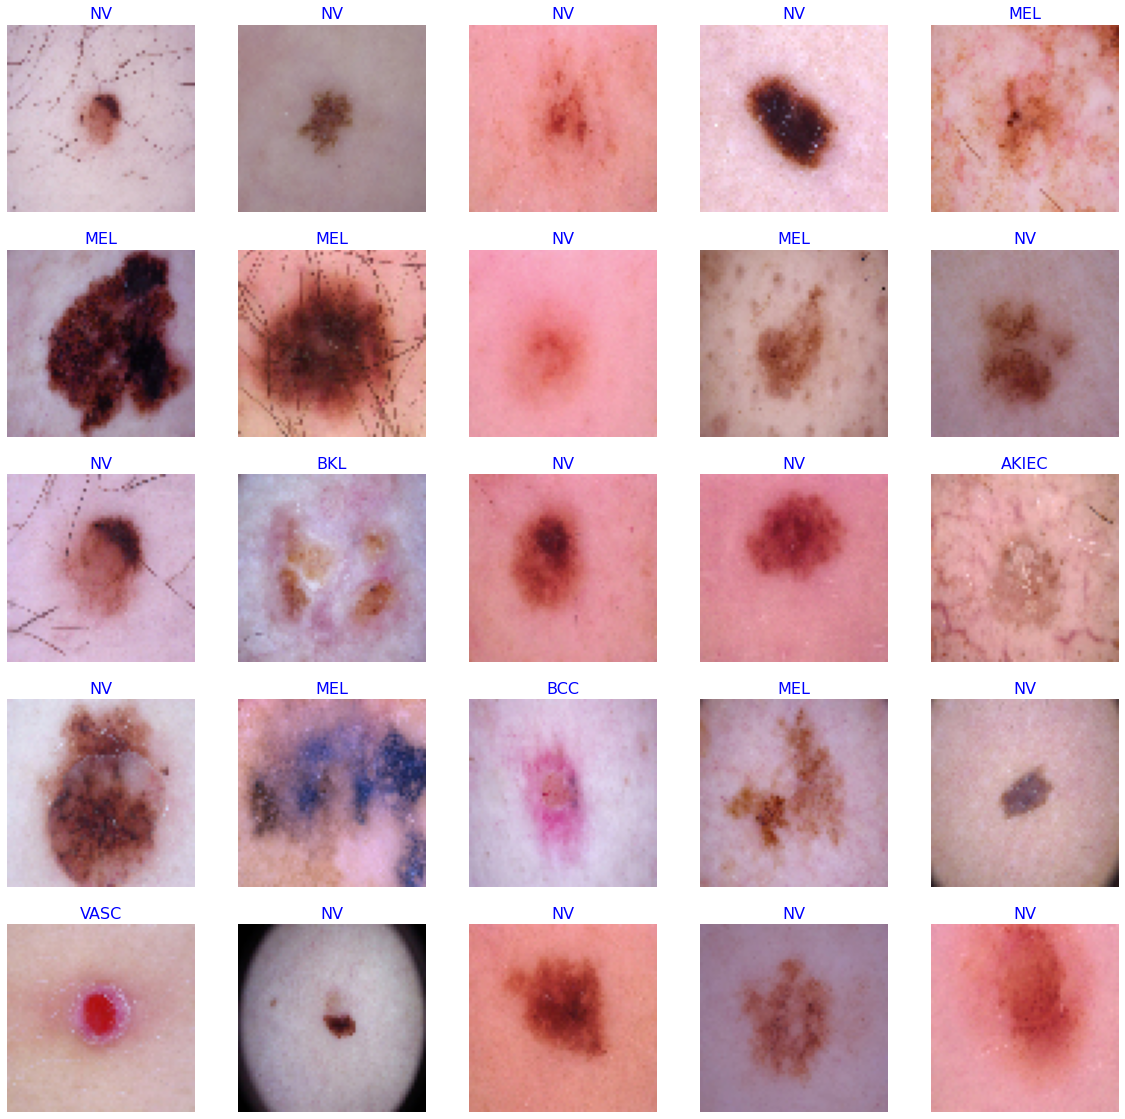

In [9]:
show_image_samples(df_gen)

In [12]:
!pwd

/content


In [13]:
df= pd.read_csv('/content/gdrive/MyDrive/Folder/data/HAM10000_metadata.csv')

In [14]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


Age has missing data

In [16]:
df.describe()

,age
count,9958.000000
mean,51.863828
std,16.968614
min,0.000000
25%,40.000000
50%,50.000000
75%,65.000000
max,85.000000


In [17]:
df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

Age has missing data

In [20]:
df['age'].fillna(int(df['age'].mean()),inplace=True)
df.isnull().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64

Age has missing data =57, so we fill the missing values with the average of the column, checking again yields no missing values for any columns

In [23]:
[df['age'].min(),df['age'].max()]

[0.0, 85.0]

In [37]:
print('Sex:', df['sex'].unique())
print('Diagnosis:',df['dx'].unique())
print('Diagnostic Criteria',df['dx_type'].unique())
print('Leison area:', df['localization'].unique())

Sex: ['male' 'female' 'unknown']
Diagnosis: ['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec']
Diagnostic Criteria ['histo' 'consensus' 'confocal' 'follow_up']
Leison area: ['scalp' 'ear' 'face' 'back' 'trunk' 'chest' 'upper extremity' 'abdomen'
 'unknown' 'lower extremity' 'genital' 'neck' 'hand' 'foot' 'acral']


This print out all the unique values of each variable regarding the patient information. Unknown sex and unknown localization were observed, they do not contribute any values and maybe removed from the dataset before proceeding to the EDA analysis.

In [38]:
df= df[df['localization'] != 'unknown']
df= df[df['sex'] != 'unknown']
df.count()

lesion_id       9771
image_id        9771
dx              9771
dx_type         9771
age             9771
sex             9771
localization    9771
dtype: int64

In [50]:
10015-9771

244

Remove all the rows with either unknown localization or sex, this yields 9771 rows, which is 244 rows less compare to the original dataset, this should be fine because we are dropping 2.4% of the original dataset

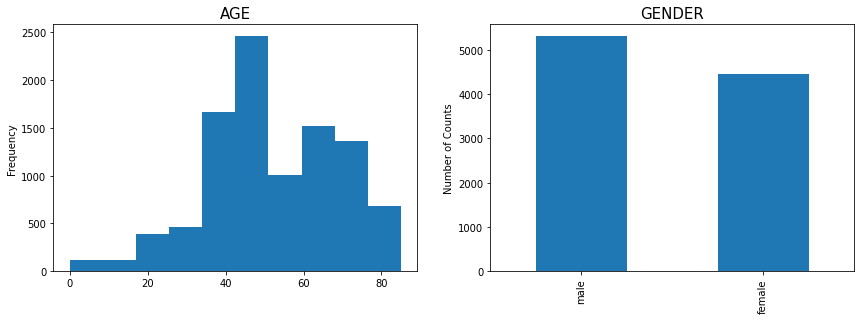

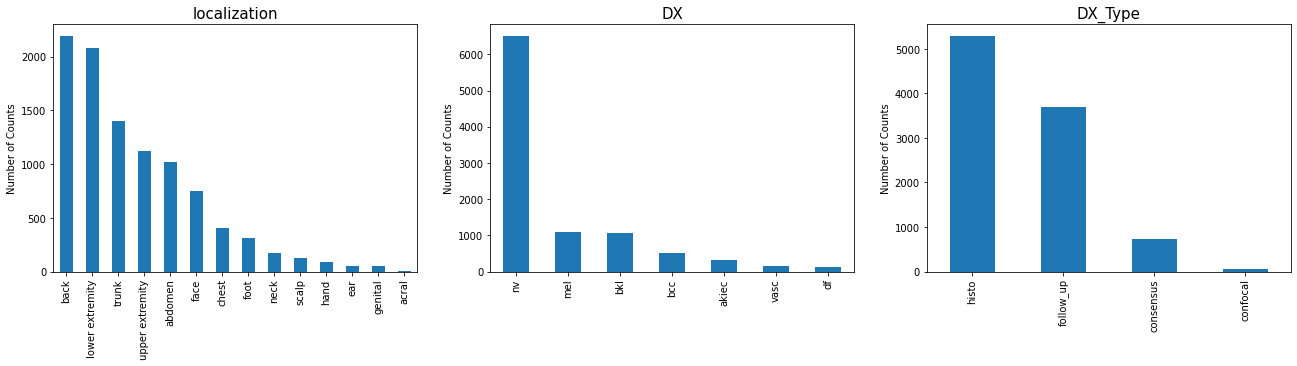

In [40]:
plt.figure(figsize=(30,10))
plt.subplot(2,4,1)
plt.title("AGE",fontsize=15)
df['age'].plot.hist()

plt.subplot(2,4,2)
plt.title("GENDER",fontsize=15)
plt.ylabel("Number of Counts")
df['sex'].value_counts().plot.bar()

plt.figure(figsize=(30,10))
plt.subplot(2,4,1)
plt.title("localization",fontsize=15)
plt.ylabel("Number of Counts")
plt.xticks(rotation=45)
df['localization'].value_counts().plot.bar()

plt.subplot(2,4,2)
plt.title("DX",fontsize=15)
plt.ylabel("Number of Counts")
df['dx'].value_counts().plot.bar()

plt.subplot(2,4,3)
plt.title("DX_Type",fontsize=15)
plt.ylabel("Number of Counts")
plt.xticks(rotation=45)
df['dx_type'].value_counts().plot.bar()

We see that most patient screened for skin tumor are in the age of 30-50, slighlty higher male patients compare to female patients in this modified dataset.

Most skin tumor localization occur in the back, lower extremity, trunk, and upper extremity.

The majority of the diagnosis for skin tumors are NV, this will essentially factor into the imbalanced label into later analysis.

Majority of the diagnostic criteria are either histopathology or follow-up.

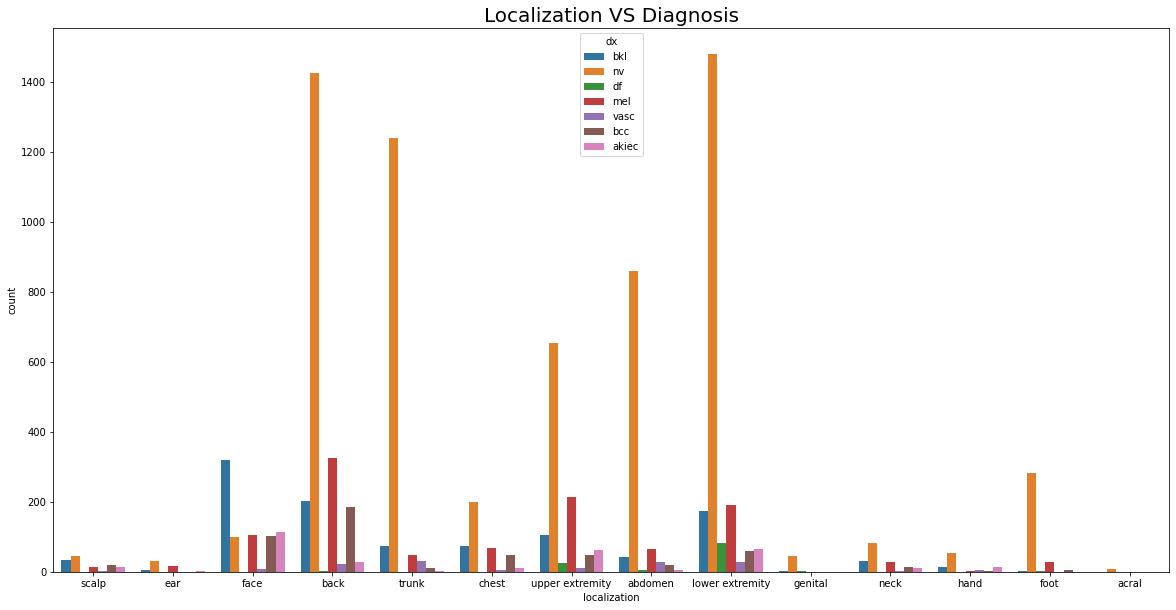

In [46]:
plt.figure(figsize=(20,10))
plt.title('Localization VS Diagnosis',fontsize = 20)
sns.countplot(x='localization', hue='dx',data=df)

A lot of the skin tumors were NV, and again, the most likely presentation area of the skin tumors are back, trunk, upper and lower extremity and abdomen. 

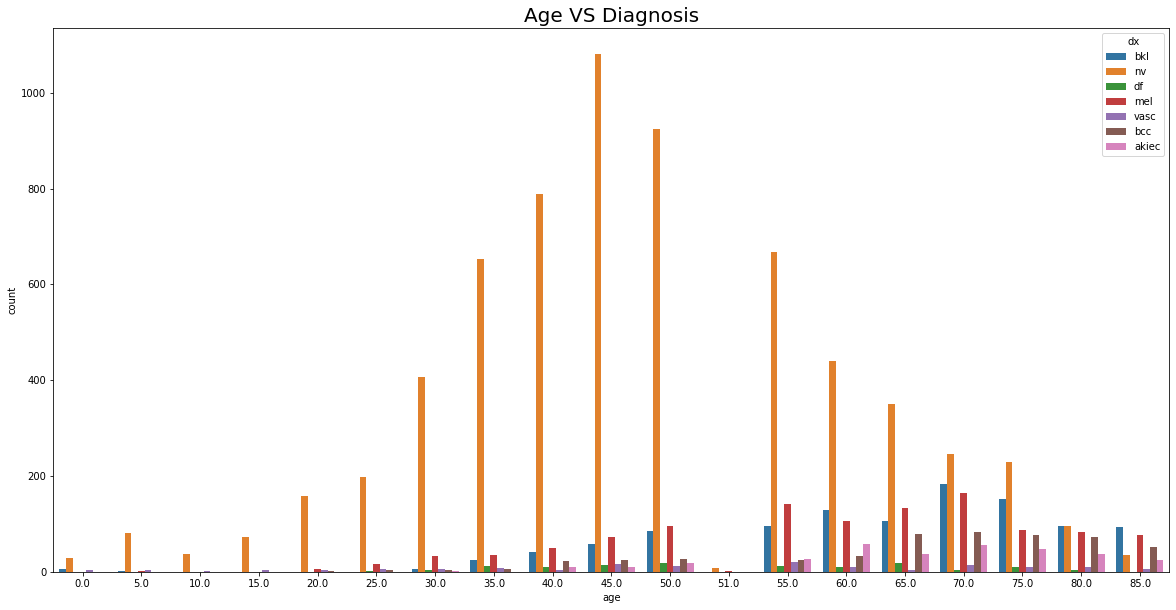

In [47]:
plt.figure(figsize=(20,10))
plt.title('Age VS Diagnosis',fontsize = 20)
sns.countplot(x='age', hue='dx',data=df)

It is quite interesting that the NV diagnosis follows pretty much a standard normal distribution. But overall, with age increasing, the count of other types of skin tumor are more frequently seen

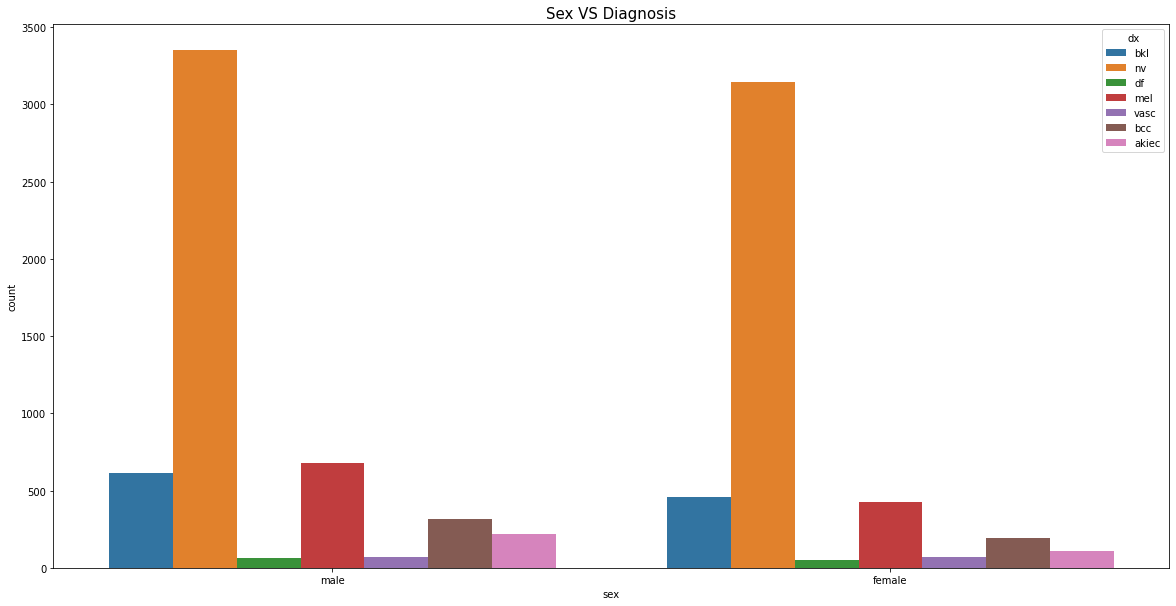

In [48]:
plt.figure(figsize=(20,10))
plt.title('Sex VS Diagnosis',fontsize = 15)
sns.countplot(x='sex', hue='dx',data=df)

NV is the most common tumor diagnosis for both men and women, and the type of tumor diagnosis is pretty much proportional in both men and women.